# Capstone Project 3: Forecasting Solar Power using ML Techniques
## *Exploring ARIMA, Prophet, XGBoost, and LSTM Methods for Solar Predictions*

### **Modeling Objective**
Predict short-term solar power generation using time series forecasting models (ARIMA, Prophet, XGBoost, and LSTM) and evaluate their performance. The goal is to forecast `AC_POWER` using historical data, weather metrics, and engineered features.

---

### **1. Load Preprocessed Data**
- Import necessary libraries.
- Load preprocessed datasets.
- Verify the structure and consistency of the loaded data.
- Finalize input features (X) and target variable (y) for training and testing.

---

### **2. Baseline Model**
- Implement a naive forecasting model using lagged values.
- Evaluate its performance using metrics **RMSE**. Consider **MAE** or **R2 Score** as potential secondary metrics to capture model strengths.

---

### **3. ARIMA Modeling**
- Perform Augmented Dickey-Fuller test to check stationarity.
- Optimize ARIMA hyperparameters using `pmdarima.auto_arima` (automated tuning of `(p, d, q)` and seasonal components `(P, D, Q, m)`).
- Fit ARIMA model on training data and generate forecasts.
- Evaluate performance using metrics (e.g., RMSE, MAE, R2).

---

### **4. Prophet Modeling**
- Train Prophet model on the training dataset, incorporating seasonal components (daily, weekly).
- Fine-tune key hyperparameters such as:
  - `seasonality_prior_scale`: Adjusts seasonality flexibility.
  - `changepoint_prior_scale`: Controls sensitivity to trend changes.
- Forecast `AC_POWER` and compare metrics (R2, MAE, RMSE).

---

### **5. XGBoost Modeling**
- **Objective**: Train an advanced machine learning regression model for solar power forecasting.
- **Steps**:
  1. Perform **Feature Engineering**:
     - Create lagged variables (e.g., previous 1-hour and 24-hour power outputs).
     - Add rolling averages/standard deviations for weather metrics (e.g., temperature, solar irradiance).
     - Incorporate time-based features (e.g., hour of day, day of week).
  2. Split Data into Training and Testing Sets:
     - Ensure temporal order is preserved (no shuffling).
  3. Train XGBoost Model:
     - Use grid search to tune hyperparameters like:
       - `learning_rate`, `max_depth`, `n_estimators`, and `min_child_weight`.
  4. Evaluate Model Performance:
     - Use RMSE, MAE, and R2 Score to compare against ARIMA and Prophet.

---

### **6. LSTM Modeling**
- **Objective**: Capture nonlinear temporal dependencies in solar power data with a deep learning approach.
- **Steps**:
  1. **Data Preparation**:
     - Reshape data into sequences for time series input format.
     - Scale features to a normalized range (e.g., StandardScaler).
  2. Define LSTM Model:
     - Build an architecture using Keras/TensorFlow with layers such as:
       - Input layer (with `Input(shape=(timesteps, features))`).
       - LSTM layer(s) (e.g., with `64` units).
       - Dense output layer (to predict `AC_POWER`).
  3. Model Training:
     - Use appropriate batch size and epochs.
     - Apply regularization techniques like dropout and early stopping to prevent overfitting.
  4. Evaluation:
     - Predict on the test set and evaluate using RMSE, MAE, and R2 Score.
  5. **Visualization**:
     - Plot actual vs predicted values to demonstrate performance.

---

### **7. Model Comparison**
- Summarize the performance of all four models (ARIMA, Prophet, XGBoost, and LSTM):

**Metrics Table**
| **Metric**        | **SARIMAX**   | **Prophet**   | **XGBoost**      | **LSTM**        |
|--------------------|---------------|---------------|------------------|-----------------|
| **R2 Score**       | 0.813709      | 0.879648      | -0.542846        | 0.982568        |
| **MAE**            | 2.255862      | 2.431660      | 0.004991         | 0.022973        |
| **RMSE**           | 4.022452      | 3.059362      | 0.009145         | 0.030747        |

---


In [833]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from pandas.tseries.offsets import DateOffset

from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

## 1. Load Data

In [505]:
os.chdir('C:/Users/aamal/Desktop/Springboard/Springboard_DataScience/Capstone-3-Solar/Data')

df = pd.read_csv('solar_cleaned.csv')

In [507]:
df.head()

,DATE_TIME,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,HOUR,DAY_OF_WEEK,MONTH,Cumulative_Yield,Normalized_Yield,Inverter_Efficiency,Plant_Efficiency
0,2020-05-15 00:00:00,1,25.184316,22.857507,0.0,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,0,4,5,6259559.0,0.0,0.0,0.052321
1,2020-05-15 00:00:00,1,25.184316,22.857507,0.0,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,0,4,5,12443204.0,0.0,0.0,0.052321
2,2020-05-15 00:00:00,1,25.184316,22.857507,0.0,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,0,4,5,19430963.0,0.0,0.0,0.052321
3,2020-05-15 00:00:00,1,25.184316,22.857507,0.0,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,0,4,5,27033923.0,0.0,0.0,0.052321
4,2020-05-15 00:00:00,1,25.184316,22.857507,0.0,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,0,4,5,34192887.0,0.0,0.0,0.052321


In [509]:
df.dtypes

DATE_TIME               object
PLANT_ID                 int64
AMBIENT_TEMPERATURE    float64
MODULE_TEMPERATURE     float64
IRRADIATION            float64
SOURCE_KEY              object
DC_POWER               float64
AC_POWER               float64
DAILY_YIELD            float64
TOTAL_YIELD            float64
HOUR                     int64
DAY_OF_WEEK              int64
MONTH                    int64
Cumulative_Yield       float64
Normalized_Yield       float64
Inverter_Efficiency    float64
Plant_Efficiency       float64
dtype: object

In [511]:
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [513]:
datetimes_full = pd.Series(pd.date_range(df.DATE_TIME.min(), 
                                         df.DATE_TIME.max(), 
                                         freq='15min'), 
                           name='DATE_TIME')
datetimes_full

0      2020-05-15 00:00:00
1      2020-05-15 00:15:00
2      2020-05-15 00:30:00
3      2020-05-15 00:45:00
4      2020-05-15 01:00:00
               ...        
3259   2020-06-17 22:45:00
3260   2020-06-17 23:00:00
3261   2020-06-17 23:15:00
3262   2020-06-17 23:30:00
3263   2020-06-17 23:45:00
Name: DATE_TIME, Length: 3264, dtype: datetime64[ns]

In [515]:
df['HOUR'] = df.DATE_TIME.dt.hour
df['DAY'] = df.DATE_TIME.dt.dayofyear
df['DAY_WEEK'] = df.DATE_TIME.dt.dayofweek
df['MINUTES_15'] = df.DATE_TIME.dt.time

#This maps the 15 minute intervals over the course of the day to ints 1-96. 
df['MINUTES_15'] = df.MINUTES_15.map({df.MINUTES_15.unique()[i-1]:i for i in range(1, 97)})
#Change day of year to day of data
df['DAY'] = df.DAY.map({df.DAY.unique()[i-1]:i for i in range(1, 35)})

In [517]:
df.columns

Index(['DATE_TIME', 'PLANT_ID', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
       'IRRADIATION', 'SOURCE_KEY', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD',
       'TOTAL_YIELD', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'Cumulative_Yield',
       'Normalized_Yield', 'Inverter_Efficiency', 'Plant_Efficiency', 'DAY',
       'DAY_WEEK', 'MINUTES_15'],
      dtype='object')

In [519]:
scaler = MinMaxScaler()
numerical_cols = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 
                   'DC_POWER', 'AC_POWER', 'Inverter_Efficiency', 'Cumulative_Yield', 
                    'Normalized_Yield', 'Plant_Efficiency']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [521]:
day = 96
#shifting to day ahead and dropping nulls cause by the shift
target = df.groupby('DATE_TIME').sum(numeric_only=True).AC_POWER.shift(-day)
target = target.dropna()

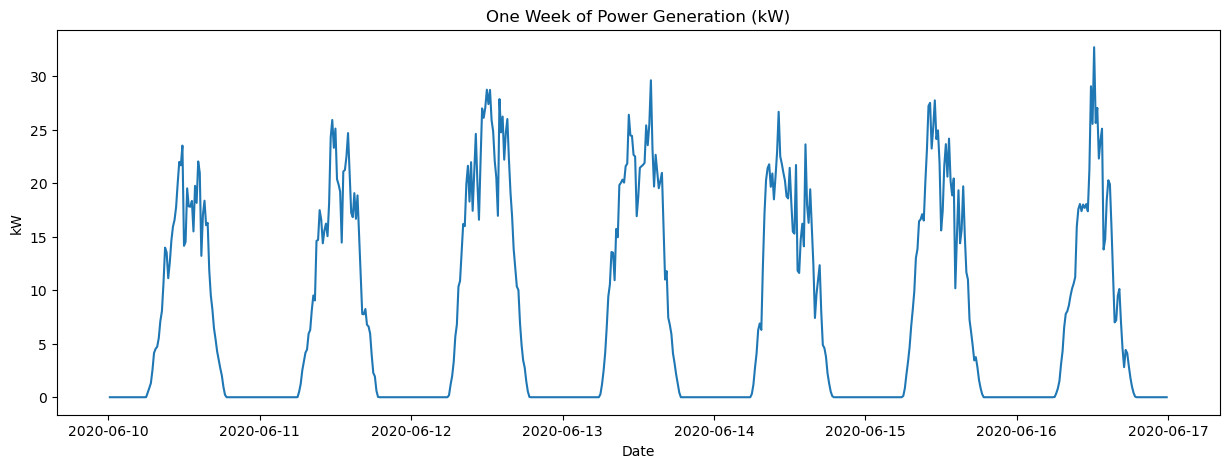

In [523]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(target[target.index > '2020-06-10'])
plt.title('One Week of Power Generation (kW)')
plt.xlabel('Date')
plt.ylabel('kW');

## 2. Baseline

The baseline model provides a benchmark to measure the effectiveness of more advanced forecasting methods. It establishes a minimum performance standard that other models must surpass to prove their value.

In [525]:
day = 96 # 15 minute intervals means 96 per day
#last 3 days for testing and the rest for training
target_test = target[-4*day:]
target_train = target[:-4*day]
#moving target back a day
baseline_preds = target.shift(day)[-4*day:]
baseline_score = np.round(root_mean_squared_error(target_test, baseline_preds), 4)
print('baseline_score RMSE: ', baseline_score)


baseline_score RMSE:  3.4671


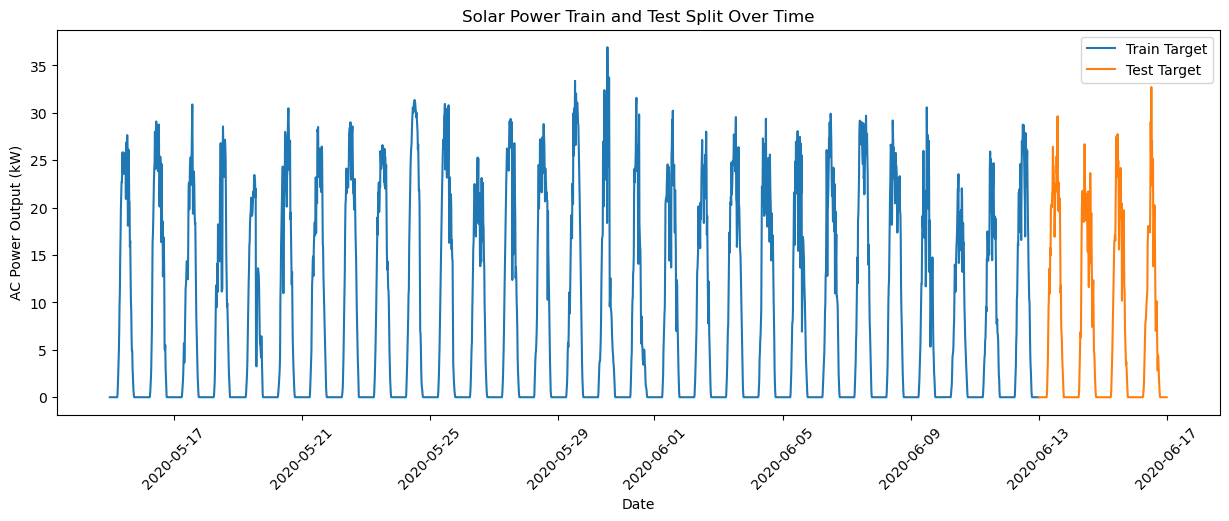

In [527]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(target_train, label='Train Target')
plt.plot(target_test, label='Test Target')
plt.xlabel('Date')  
plt.ylabel('AC Power Output (kW)')  
plt.title('Solar Power Train and Test Split Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.show()

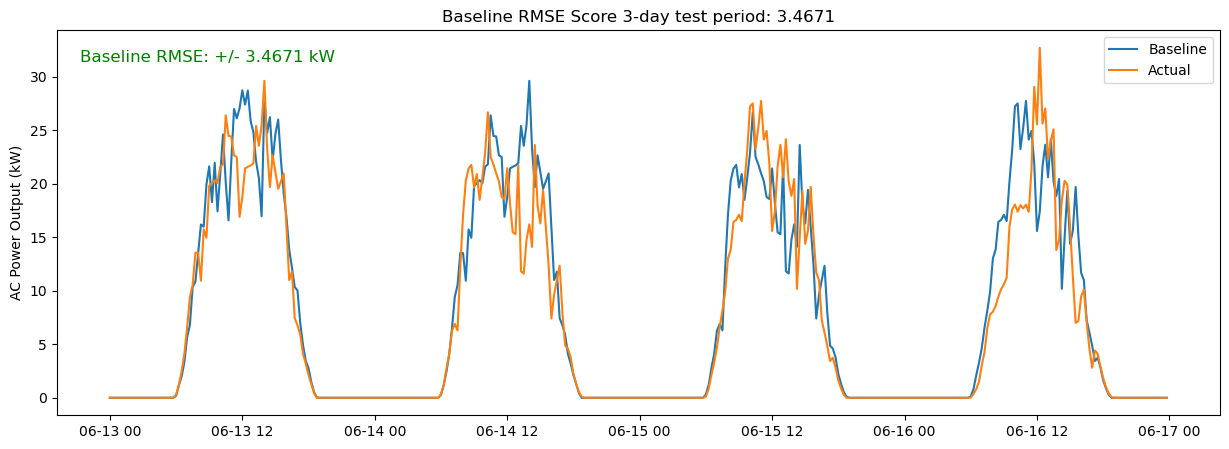

In [573]:
fig, ax = plt.subplots(figsize=(15,5))
#plt.plot(X[X.index > '2020-06-10'].index, y_pred[X.index > '2020-06-10'], alpha=0.5)
plt.plot(baseline_preds, label='baseline')
plt.plot(target_test);
plt.ylabel('AC Power Output (kW)')  
plt.title(f'Baseline RMSE Score 3-day test period: {baseline_score}')
ax.text(0.02, 0.95, f'Baseline RMSE: +/- {baseline_score:.4f} kW', transform=ax.transAxes, 
        fontsize=12, color='green', verticalalignment='top', horizontalalignment='left')
plt.legend(['Baseline', 'Actual']);

## 3. ARIMA 

In [531]:
pred_gen=df.copy()
pred_gen=pred_gen.groupby('DATE_TIME').sum()
pred_gen=pred_gen['AC_POWER'][-288:].reset_index()
pred_gen.set_index('DATE_TIME',inplace=True)
pred_gen.head()

,AC_POWER
DATE_TIME,
2020-06-15 00:00:00,0.0
2020-06-15 00:15:00,0.0
2020-06-15 00:30:00,0.0
2020-06-15 00:45:00,0.0
2020-06-15 01:00:00,0.0


ARIMA models require the input time series to be stationary. Stationary means the statistical properties (mean, variance, autocorrelation) of the time series don't change over time.

In [533]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(pred_gen['AC_POWER'])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.545056416353649
p-value : 0.006902601066407618
#Lags Used : 14
Number of Observations Used : 273
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


- Data meets ARIMA's assumptions

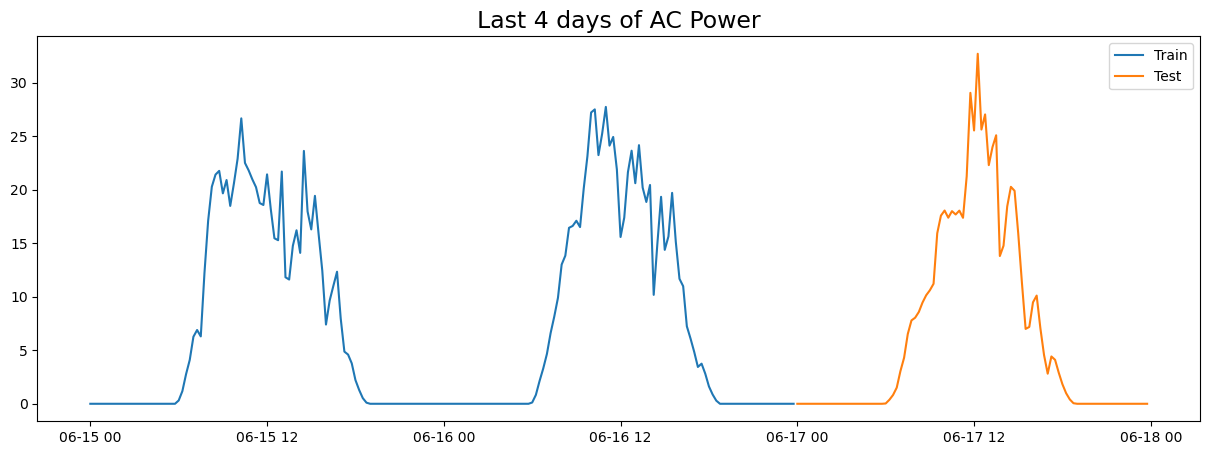

In [535]:
train=pred_gen[:192]
test=pred_gen[-96:]
plt.figure(figsize=(15,5))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.title('Last 4 days of AC Power',fontsize=17)
plt.legend()
plt.show()

In [537]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(train,
                         start_p=0,d=1,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96,
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[96]             : AIC=487.920, Time=0.56 sec
 ARIMA(1,1,0)(1,1,0)[96]             : AIC=486.503, Time=2.86 sec
 ARIMA(0,1,1)(0,1,1)[96]             : AIC=481.382, Time=3.33 sec
 ARIMA(0,1,1)(0,1,0)[96]             : AIC=479.382, Time=1.18 sec
 ARIMA(0,1,1)(1,1,0)[96]             : AIC=481.382, Time=4.56 sec
 ARIMA(0,1,1)(1,1,1)[96]             : AIC=483.382, Time=5.29 sec
 ARIMA(1,1,1)(0,1,0)[96]             : AIC=inf, Time=4.80 sec
 ARIMA(0,1,2)(0,1,0)[96]             : AIC=471.041, Time=2.31 sec
 ARIMA(0,1,2)(1,1,0)[96]             : AIC=473.041, Time=8.34 sec
 ARIMA(0,1,2)(0,1,1)[96]             : AIC=473.041, Time=9.08 sec
 ARIMA(0,1,2)(1,1,1)[96]             : AIC=475.041, Time=9.36 sec
 ARIMA(1,1,2)(0,1,0)[96]             : AIC=inf, Time=8.97 sec
 ARIMA(0,1,3)(0,1,0)[96]             : AIC=inf, Time=8.75 sec
 ARIMA(1,1,3)(0,1,0)[96]             : AIC=inf, Time=9.40 sec
 ARIMA(0,1,2)(0,1,0)[96] intercept   : AIC=473.04

**ARIMA(p, d, q)**: 
1. **p = 0** (Auto-Regressive Term):
   - No past values of `DC_POWER` are used in the model to predict future values.
   - This means the model does not account for the linear relationship between a value and its lags.
2. **d = 1** (Differencing Term):
   - The time series is differenced once to make it stationary (remove trends).
   - Differencing involves subtracting the previous value from the current value.
3. **q = 2** (Moving Average Term):
   - The model uses 2 lagged residuals (errors) from previous time steps to predict the current value.
   - This helps in correcting prediction errors dynamically.

**Seasonal ARIMA(P, D, Q, m)**:
1. **P = 0** (Seasonal Auto-Regressive Term):
   - No seasonal auto-regression is applied. The model doesn't use previous seasonal periods to inform predictions.
2. **D = 1** (Seasonal Differencing Term):
   - Seasonal differencing is performed once to remove seasonal patterns in the data.
3. **Q = []** (Seasonal Moving Average Term):
   - No seasonal moving average terms are included in the model.
4. **m = 96** (Seasonal Periodicity):
   - Data points are recorded every 15 minutes, 96 could represent one day (96 x 15 minutes = 24 hours).
- Limitations:
  - The model does not include auto-regression (`p = 0` and `P = 0`), which could limit its ability to capture relationships over longer lags.


In [38]:
from pandas.tseries.offsets import DateOffset
future_dates = [test.index[-1] + DateOffset(minutes=x) for x in range(0,2910,15) ]

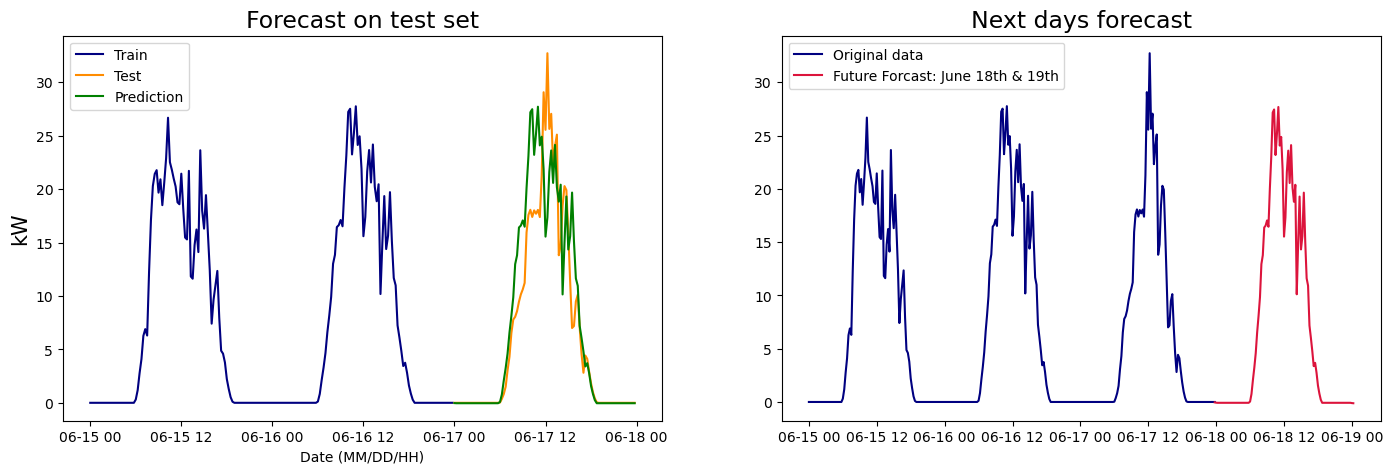

In [545]:
prediction=pd.DataFrame(arima_model.predict(n_periods=96),index=test.index)
prediction.columns=['predicted_yield']

fig,ax= plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(17,5))
ax[0].plot(train,label='Train',color='navy')
ax[0].plot(test,label='Test',color='darkorange')
ax[0].plot(prediction,label='Prediction',color='green')
ax[0].legend()
ax[0].set_title('Forecast on test set',size=17)
ax[0].set_ylabel('kW',fontsize=15)
ax[0].set_xlabel('Date (MM/DD/HH)')

f_prediction=pd.DataFrame(arima_model.predict(n_periods=194),index=future_dates)
f_prediction.columns=['predicted_yield']
ax[1].plot(pred_gen,label='Original data',color='navy')
ax[1].plot(f_prediction,label='Future Forcast: June 18th & 19th',color='crimson')
ax[1].legend()
ax[1].set_title('Next days forecast',size=17)
ax[0].set_xlabel('Date (MM/DD/HH)')
plt.show()

In [547]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  192
Model:             SARIMAX(0, 1, 2)x(0, 1, [], 96)   Log Likelihood                -232.521
Date:                             Mon, 28 Apr 2025   AIC                            471.041
Time:                                     13:42:34   BIC                            478.703
Sample:                                 06-15-2020   HQIC                           474.137
                                      - 06-16-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4379      0.088     -4.967      0.000      -0.611      -0.265
ma.L2         -0.4026      0.058     -6.912      0.000      -0.517      -0.288
sigma2         7.7327      0.640     12.091      0.000       6.479       8.986
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               118.39
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.93   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model Parameters and Statistics**

**Model Parameters**
| **Parameter**   | **Value**         | **Description**                                                                 |
|------------------|-------------------|---------------------------------------------------------------------------------|
| `ma.L1`         | -0.4379           | Moving Average coefficient for lag 1; indicates the influence of residuals at lag 1. |
| `ma.L2`         | -0.4026           | Moving Average coefficient for lag 2; captures the influence of residuals at lag 2. |
| `sigma2`        | 7.7327            | Variance of residuals; measures the model's error variance.                     |



**Model Statistics**
| **Statistic**    | **Value**         | **Description**                                                                 |
|-------------------|-------------------|---------------------------------------------------------------------------------|
| Log Likelihood    | -231.520          | Indicates model fit; higher (less negative) values suggest a better fit.        |
| AIC               | 471.041           | Akaike Information Criterion; penalizes complexity. Lower values are preferred. |
| BIC               | 478.703           | Bayesian Information Criterion; penalizes complexity more strongly than AIC.    |
| HQIC              | 474.137           | Hannan-Quinn Criterion; balances goodness of fit with model simplicity.         |



 **Diagnostic Tests**
| **Test**          | **Value**         | **Description**                                                                 |
|-------------------|-------------------|---------------------------------------------------------------------------------|
| Ljung-Box (Q)     | Prob(Q) = 0.77    | Tests for autocorrelation in residuals. A high p-value suggests residuals are uncorrelated. |
| Jarque-Bera (JB)  | Prob(JB) = 0.00   | Tests residual normality. A low p-value indicates non-normal residuals.         |
| Heteroskedasticity (H) | Prob(H) = 0.00 | Tests for constant variance in residuals. A low p-value suggests heteroskedasticity (changing variance). |



**Key Takeaways**
- The ARIMA model effectively captures short-term dependencies but may exhibit residuals with non-normal distribution and changing variance.
- Metrics like AIC and Log Likelihood show a reasonably good fit, but further improvement may be achieved by refining the model.

---



While ARIMA is effective in capturing dependencies and trends, it may not handle seasonality or external regressors like some weather metrics as naturally. Next, we'll explore Prophet, which excels in incorporating such effects.

 Improvements for ARIMA:  adding additional regressors or exploring ensemble methods? 
Slight modifications for tuning?

## 4. Prophet 

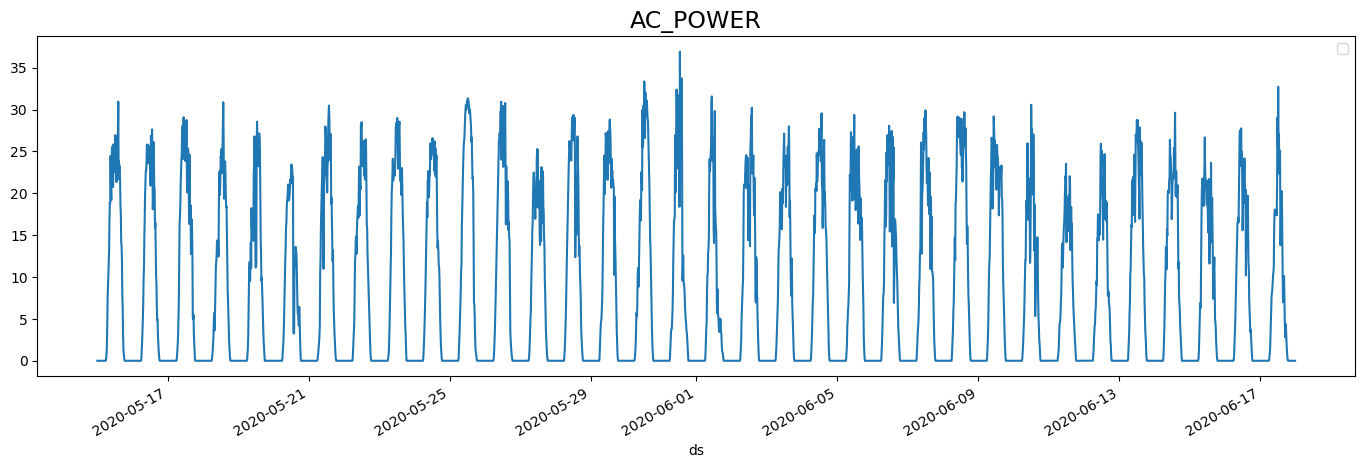

In [549]:
from prophet import Prophet
pred_gen2=df.copy()
pred_gen2=pred_gen2.groupby('DATE_TIME')['AC_POWER'].sum().reset_index()
pred_gen2.rename(columns={'DATE_TIME':'ds','AC_POWER':'y'},inplace=True)
pred_gen2.plot(x='ds',y='y',figsize=(17,5))
plt.legend('')
plt.title('AC_POWER',size=17)
plt.show()

In [551]:
m = Prophet()
m.fit(pred_gen2)

13:50:29 - cmdstanpy - INFO - Chain [1] start processing
13:50:30 - cmdstanpy - INFO - Chain [1] done processing


In [553]:
future = [pred_gen2['ds'].iloc[-1:] + DateOffset(minutes=x) for x in range(0,2910,15) ]
time1=pd.DataFrame(future).reset_index().drop('index',axis=1)
time1.rename(columns={3261:'ds'},inplace=True)

In [555]:
time1.head()

,ds
0,2020-06-17 23:45:00
1,2020-06-18 00:00:00
2,2020-06-18 00:15:00
3,2020-06-18 00:30:00
4,2020-06-18 00:45:00


In [557]:
timeline=pd.DataFrame(pred_gen2['ds'])
fut = pd.concat([timeline, time1], ignore_index=True)

fut.tail()

,ds
3451,2020-06-19 23:00:00
3452,2020-06-19 23:15:00
3453,2020-06-19 23:30:00
3454,2020-06-19 23:45:00
3455,2020-06-20 00:00:00


In [559]:
forecast = m.predict(fut)

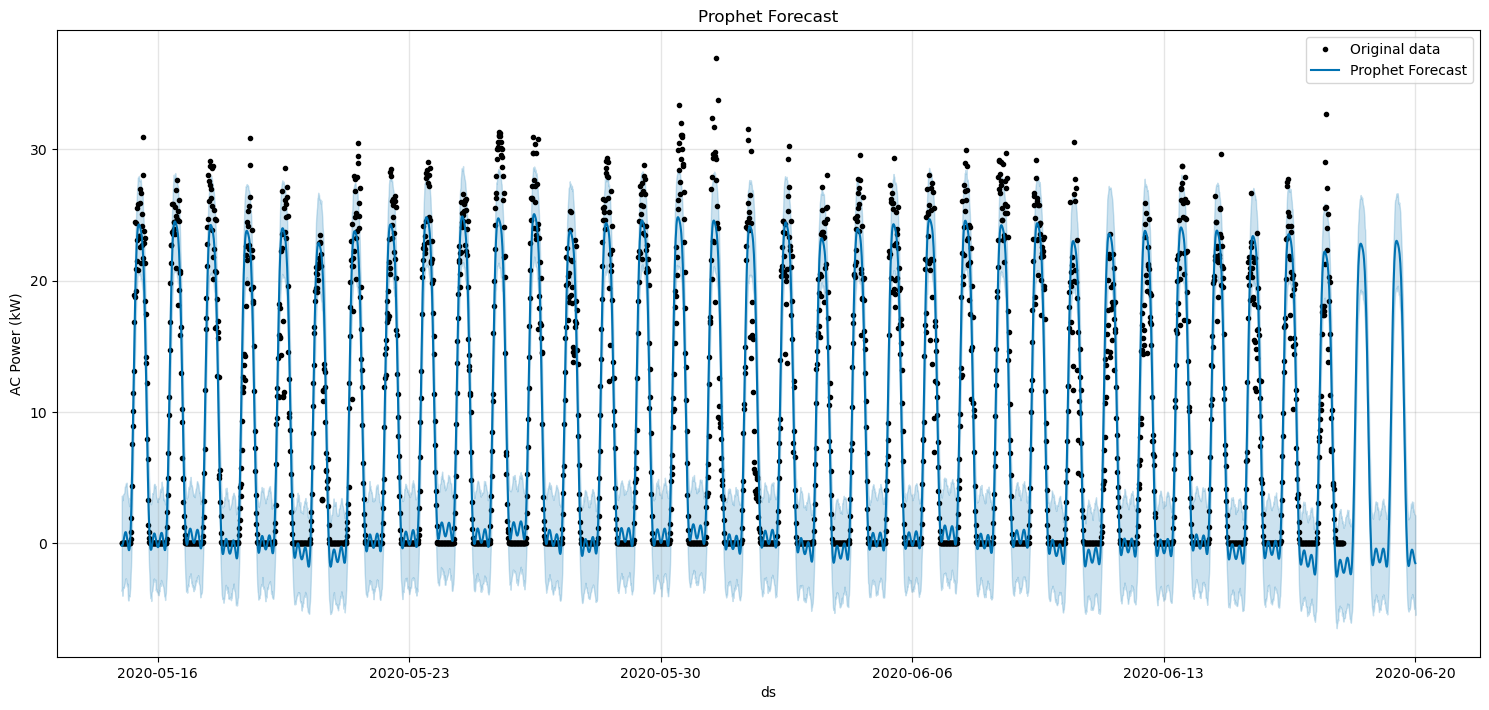

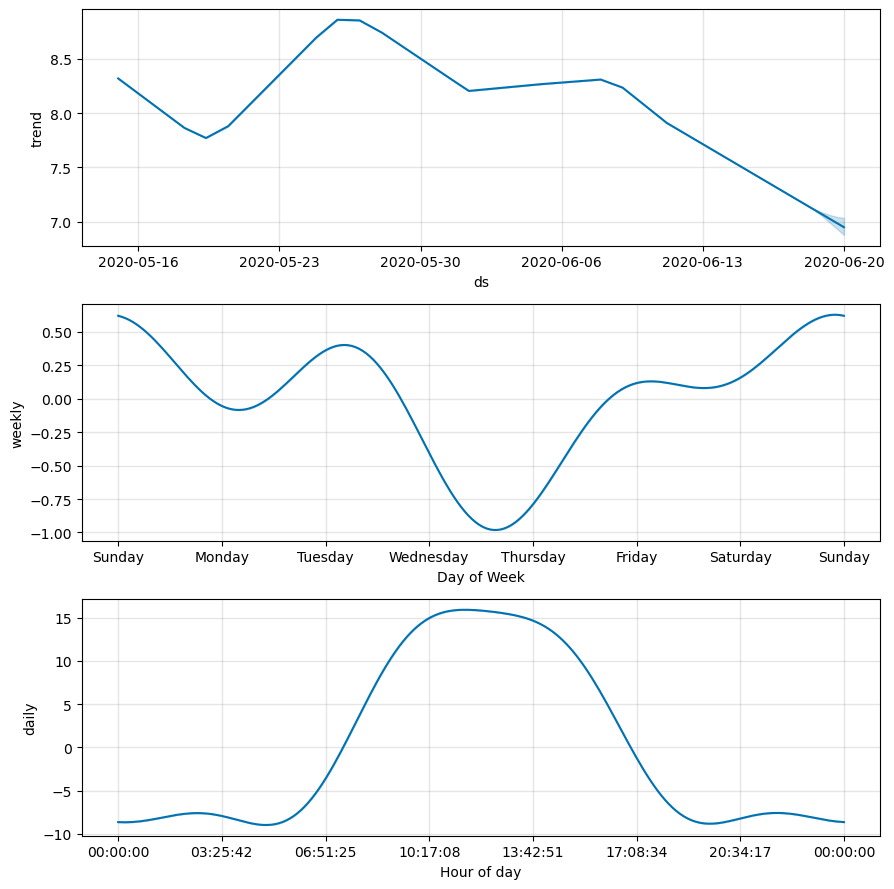

In [561]:
m.plot(forecast,figsize=(15,7))
plt.title('ok')
plt.legend(labels=['Original data','Prophet Forecast'])
plt.ylabel('AC Power (kW)')
plt.title('Prophet Forecast')
plt.show()

fig2 = m.plot_components(forecast)
plt.show()

#### **Overview**
 
The Prophet model decomposes the time series into three components: **Trend**, **Weekly Seasonality**, and **Daily Seasonality**, offering insights into solar power generation patterns.

---
**1. Trend Component**
- **Description**:
  - The long-term movement in solar power output is captured.
  - Gradual increases or decreases highlight changes in generation efficiency or environmental conditions.

- **Key Insights**:
  - From mid-May to early June, the upward trend suggests seasonal improvements, likely due to longer daylight hours.
  - The declining trend toward late June could reflect environmental factors or weather changes.

**2. Weekly Seasonality**
- **Description**:
  - Displays variations in solar power output across the days of the week.

- **Key Insights**:
  - **Peak on Sunday**: Indicates higher solar power generation potential, possibly due to favorable weather conditions.
  - **Trough on Thursday**: Consistently lower output may indicate specific recurring conditions.

**3. Daily Seasonality**
- **Description**:
  - Shows variations in power output throughout the day.

- **Key Insights**:
  - **Midday Peak**: Highest power output aligns with the sun's position at its zenith, maximizing solar energy potential.
  - **Morning and Evening Dips**: Minimal output during early morning and late evening reflects lower sunlight availability.

---
 **Actionable Insights**
1. **Operational Optimization**:
   - The midday peak can inform grid managers to allocate more resources or schedule high-demand operations during these periods.
   - Awareness of weekly troughs (e.g., Thursday) can guide predictive maintenance or adjustments in power distribution.

2. **Future Model Refinements**:
   - Incorporating weather metrics (e.g., cloud cover) as additional regressors can enhance forecast precision.
---


In [964]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error, root_mean_squared_error
test2=pd.DataFrame(test.index)
test2.rename(columns={'DATE_TIME':'ds'},inplace=True)
test_prophet=m.predict(test2)

In [945]:
print('SARIMAX R2 Score: %f' % (r2_score(prediction['predicted_yield'],test['AC_POWER'])))
print('Prophet R2 Score: %f' % (r2_score(test['AC_POWER'],test_prophet['yhat'])))
print('-'*15)
print('SARIMAX MAE Score: %f' % (mean_absolute_error(prediction['predicted_yield'],test['AC_POWER'])))
print('Prophet MAE Score: %f' % (mean_absolute_error(test['AC_POWER'],test_prophet['yhat'])))
print('-'*15)
print('SARIMAX RMSE Score: %f' % (root_mean_squared_error(prediction['predicted_yield'],test['AC_POWER'])))
print('Prophet RMSE Score: %f' % (root_mean_squared_error(test['AC_POWER'],test_prophet['yhat'])))

SARIMAX R2 Score: 0.813709
Prophet R2 Score: 0.879648
---------------
SARIMAX MAE Score: 2.255862
Prophet MAE Score: 2.431660
---------------
SARIMAX RMSE Score: 4.022452
Prophet RMSE Score: 3.059362


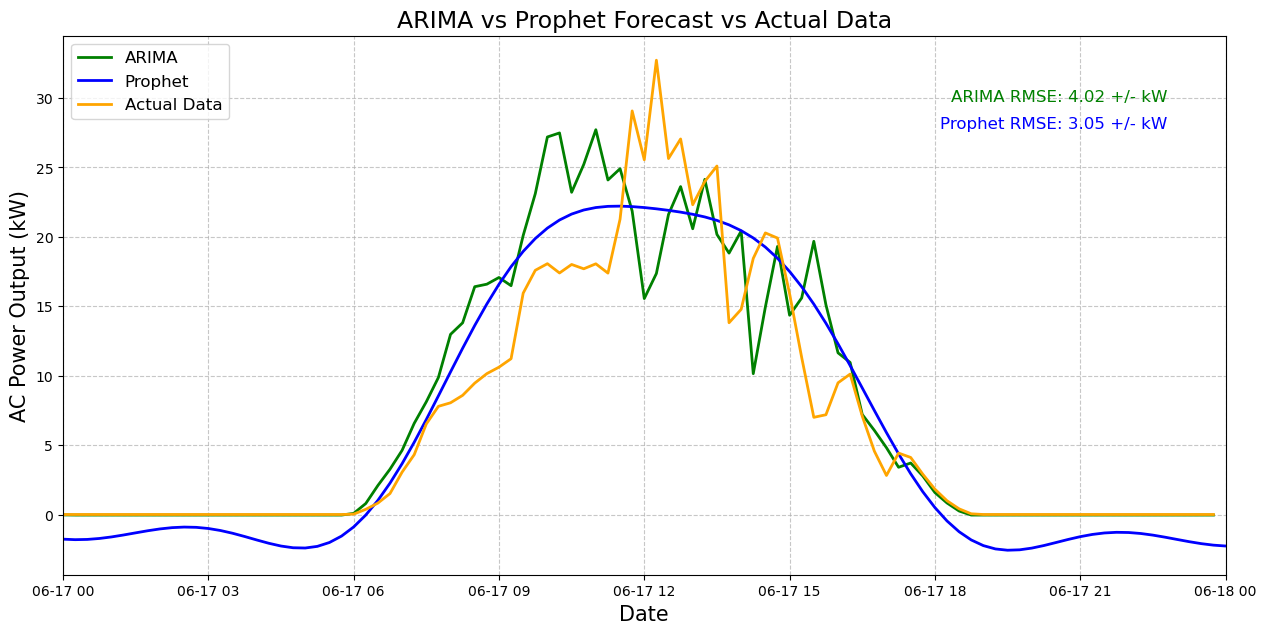

In [943]:
fig, ax = plt.subplots(figsize=(15, 7))

# Plot ARIMA predictions
ax.plot(test.index, prediction['predicted_yield'], label='ARIMA', color='green', linewidth=2)

# Plot Prophet forecasts
ax.plot(forecast['ds'], forecast['yhat'], label='Prophet', color='blue', linewidth=2)

# Plot original data (actual values)
ax.plot(test.index, test.values, label='Actual Data', color='orange', linewidth=2)

# Zoom in on a specific date range
ax.set_xlim(pd.Timestamp('2020-06-17'), pd.Timestamp('2020-06-18'))

# Add title, labels, and legend
ax.set_title('ARIMA vs Prophet Forecast vs Actual Data', fontsize=17)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('AC Power Output (kW)', fontsize=15)
ax.legend(loc='upper left', fontsize=12)

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Add annotations for RMSE in the upper-right corner
ax.text(0.95, 0.90, f'ARIMA RMSE: 4.02 +/- kW', transform=ax.transAxes, fontsize=12,
        color='green', verticalalignment='top', horizontalalignment='right')
ax.text(0.95, 0.85, f'Prophet RMSE: 3.05 +/- kW', transform=ax.transAxes, fontsize=12,
        color='blue', verticalalignment='top', horizontalalignment='right')

# Show plot
plt.show()

#### **Overview**
 
The Prophet model decomposes the time series into three components: **Trend**, **Weekly Seasonality**, and **Daily Seasonality**, offering insights into solar power generation patterns.

---
**1. Trend Component**
- **Description**:
  - The long-term movement in solar power output is captured.
  - Gradual increases or decreases highlight changes in generation efficiency or environmental conditions.

- **Key Insights**:
  - From mid-May to early June, the upward trend suggests seasonal improvements, likely due to longer daylight hours.
  - The declining trend toward late June could reflect environmental factors or weather changes.

**2. Weekly Seasonality**
- **Description**:
  - Displays variations in solar power output across the days of the week.

- **Key Insights**:
  - **Peak on Sunday**: Indicates higher solar power generation potential, possibly due to favorable weather conditions.
  - **Trough on Thursday**: Consistently lower output may indicate specific recurring conditions.

**3. Daily Seasonality**
- **Description**:
  - Shows variations in power output throughout the day.

- **Key Insights**:
  - **Midday Peak**: Highest power output aligns with the sun's position at its zenith, maximizing solar energy potential.
  - **Morning and Evening Dips**: Minimal output during early morning and late evening reflects lower sunlight availability.

---
 **Actionable Insights**
1. **Operational Optimization**:
   - The midday peak can inform grid managers to allocate more resources or schedule high-demand operations during these periods.
   - Awareness of weekly troughs (e.g., Thursday) can guide predictive maintenance or adjustments in power distribution.

2. **Future Model Refinements**:
   - Incorporating weather metrics (e.g., cloud cover) as additional regressors can enhance forecast precision.
---


In [563]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error, root_mean_squared_error
test2=pd.DataFrame(test.index)
test2.rename(columns={'DATE_TIME':'ds'},inplace=True)
test_prophet=m.predict(test2)

In [565]:
print('SARIMAX R2 Score: %f' % (r2_score(prediction['predicted_yield'],test['AC_POWER'])))
print('Prophet R2 Score: %f' % (r2_score(test['AC_POWER'],test_prophet['yhat'])))
print('-'*15)
print('SARIMAX MAE Score: %f' % (mean_absolute_error(prediction['predicted_yield'],test['AC_POWER'])))
print('Prophet MAE Score: %f' % (mean_absolute_error(test['AC_POWER'],test_prophet['yhat'])))
print('-'*15)
print('SARIMAX RMSE Score: %f' % (root_mean_squared_error(prediction['predicted_yield'],test['AC_POWER'])))
print('Prophet RMSE Score: %f' % (root_mean_squared_error(test['AC_POWER'],test_prophet['yhat'])))

SARIMAX R2 Score: 0.813709
Prophet R2 Score: 0.879648
---------------
SARIMAX MAE Score: 2.255862
Prophet MAE Score: 2.431660
---------------
SARIMAX RMSE Score: 4.022452
Prophet RMSE Score: 3.059362


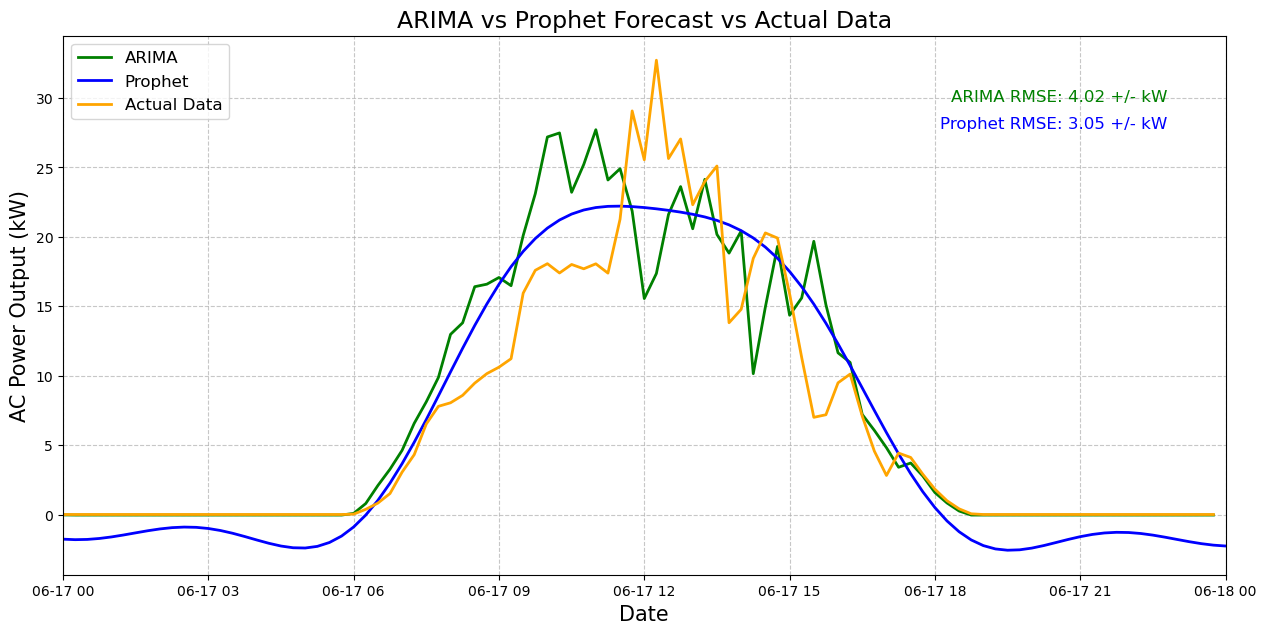

In [587]:
fig, ax = plt.subplots(figsize=(15, 7))

# Plot ARIMA predictions
ax.plot(test.index, prediction['predicted_yield'], label='ARIMA', color='green', linewidth=2)

# Plot Prophet forecasts
ax.plot(forecast['ds'], forecast['yhat'], label='Prophet', color='blue', linewidth=2)

# Plot original data (actual values)
ax.plot(test.index, test.values, label='Actual Data', color='orange', linewidth=2)

# Zoom in on a specific date range
ax.set_xlim(pd.Timestamp('2020-06-17'), pd.Timestamp('2020-06-18'))

# Add title, labels, and legend
ax.set_title('ARIMA vs Prophet Forecast vs Actual Data', fontsize=17)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('AC Power Output (kW)', fontsize=15)
ax.legend(loc='upper left', fontsize=12)

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Add annotations for RMSE in the upper-right corner
ax.text(0.95, 0.90, f'ARIMA RMSE: 4.02 +/- kW', transform=ax.transAxes, fontsize=12,
        color='green', verticalalignment='top', horizontalalignment='right')
ax.text(0.95, 0.85, f'Prophet RMSE: 3.05 +/- kW', transform=ax.transAxes, fontsize=12,
        color='blue', verticalalignment='top', horizontalalignment='right')

# Show plot
plt.show()


### **Model Evaluation Metrics: ARIMA vs Prophet**
 **Overview**
The metrics below compare the performance of ARIMA and Prophet models for forecasting `AC_POWER`. The evaluation focused on three key metrics: **R2 Score**, **MAE**, and **RMSE**.

---
 **Performance Metrics**
| **Metric**        | **ARIMA**       | **Prophet**       | **Description**                                                  |
|--------------------|-------------------|-------------------|------------------------------------------------------------------|
| **R2 Score**       | 0.813709          | 0.879648          | Measures explained variance; higher values indicate better fit. |
| **MAE**            | 2.255862          | 2.431660          | Mean Absolute Error; lower values indicate fewer average errors.|
| **RMSE**           | 4.022452          | 3.059362          | Root Mean Squared Error; penalizes large deviations more heavily.|

---
 **Key Insights**
1. **R2 Score**:
   - Prophet achieves a higher R2 score (0.879648) than SARIMAX (0.813709), indicating better overall variance explanation.
   - This suggests Prophet excels at modeling trends and seasonality in the data.

2. **MAE**:
   - SARIMAX performs better in terms of MAE (2.255862), indicating fewer average errors between predicted and actual values.
   - This could make SARIMAX more reliable in scenarios where minimizing absolute errors is crucial.

3. **RMSE**:
   - Prophet outperforms SARIMAX with a lower RMSE (3.059362 vs 4.022452), highlighting its ability to handle variations in solar power output effectively.

---
 **Best Model Selection**
Prophet's higher R2 score and lower RMSE suggest it is more effective for capturing complex patterns and variability in solar power generation.

---


### **Potentials for Fine-tuning Models to Improve Performance**
 **1. Hyperparameter Optimization**
- **Purpose**: Improve model performance by systematically testing different parameter combinations.
- **Techniques**:
  1. Grid Search
  2. Random Search
  3. Automated Tools:
     - `optuna` for automated hyperparameter tuning.
     - Prophet: Optimize parameters like `seasonality_prior_scale` and `changepoint_prior_scale`.

 **2. Cross Validation**
- **Purpose**: Evaluate model performance on unseen data and avoid overfitting.
- **Techniques**:
    1. Rolling Window Validation
    2. Walk-Forward Validation

**3. Feature Engineering**
- **Purpose**: Enhance predictive potential and improve model accuracy by extracting meaningful features.
- **Techniques**:
  1. Lagged Features
  2. Rolling Statistics
  3. Time-Based Features

### **Alternative Forecasting Methods for Future Projects**
 **1. Ensemble Models**
- **Description**:
  - Combine the strengths of ARIMA and Prophet by averaging or weighting their predictions.
  - Example: Use ARIMA for short-term dependencies and Prophet for trends/seasonality.
- **Benefits**:
  - Reduces the weaknesses of individual models.
  - Improves robustness by leveraging complementary features.

 **2. XGBoost or LightGBM**
- **Description**:
  - Advanced tree-based machine learning models capable of handling time series after feature engineering (e.g., lagged variables, rolling statistics).
- **Benefits**:
  - Handles nonlinear relationships effectively.
  - Allows inclusion of additional features like weather or other external factors.
- **Use Case**:
  - Suitable for datasets with complex, nonlinear patterns or multiple influencing factors.

 **3. LSTM (Long Short-Term Memory)**
- **Description**:
  - A specialized type of recurrent neural network (RNN) that learns long-term and short-term dependencies in sequential data.
- **Benefits**:
  - Captures complex temporal patterns and relationships across time.
  - Can handle large, unstructured time series data.
- **Use Case**:
  - Suitable for solar power forecasting where long-term dependencies exist.



### **Model Evaluation Metrics: ARIMA vs Prophet**
 **Overview**
The metrics below compare the performance of ARIMA and Prophet models for forecasting `AC_POWER`. The evaluation focused on three key metrics: **R2 Score**, **MAE**, and **RMSE**.

---
 **Performance Metrics**
| **Metric**        | **ARIMA**       | **Prophet**       | **Description**                                                  |
|--------------------|-------------------|-------------------|------------------------------------------------------------------|
| **R2 Score**       | 0.813709          | 0.879648          | Measures explained variance; higher values indicate better fit. |
| **MAE**            | 2.255862          | 2.431660          | Mean Absolute Error; lower values indicate fewer average errors.|
| **RMSE**           | 4.022452          | 3.059362          | Root Mean Squared Error; penalizes large deviations more heavily.|

---
 **Key Insights**
1. **R2 Score**:
   - Prophet achieves a higher R2 score (0.879648) than SARIMAX (0.813709), indicating better overall variance explanation.
   - This suggests Prophet excels at modeling trends and seasonality in the data.

2. **MAE**:
   - SARIMAX performs better in terms of MAE (2.255862), indicating fewer average errors between predicted and actual values.
   - This could make SARIMAX more reliable in scenarios where minimizing absolute errors is crucial.

3. **RMSE**:
   - Prophet outperforms SARIMAX with a lower RMSE (3.059362 vs 4.022452), highlighting its ability to handle variations in solar power output effectively.

---
 **Best Model Selection**
Prophet's higher R2 score and lower RMSE suggest it is more effective for capturing complex patterns and variability in solar power generation.

---

### **Potentials for Fine-tuning Models to Improve Performance**
 **1. Hyperparameter Optimization**
- **Purpose**: Improve model performance by systematically testing different parameter combinations.
- **Techniques**:
  1. Grid Search
  2. Random Search
  3. Automated Tools:
     - `optuna` for automated hyperparameter tuning.
     - Prophet: Optimize parameters like `seasonality_prior_scale` and `changepoint_prior_scale`.

 **2. Cross Validation**
- **Purpose**: Evaluate model performance on unseen data and avoid overfitting.
- **Techniques**:
    1. Rolling Window Validation
    2. Walk-Forward Validation

**3. Feature Engineering**
- **Purpose**: Enhance predictive potential and improve model accuracy by extracting meaningful features.
- **Techniques**:
  1. Lagged Features
  2. Rolling Statistics
  3. Time-Based Features

### **Alternative Forecasting Methods for Future Projects**
 **1. Ensemble Models**
- **Description**:
  - Combine the strengths of ARIMA and Prophet by averaging or weighting their predictions.
  - Example: Use ARIMA for short-term dependencies and Prophet for trends/seasonality.
- **Benefits**:
  - Reduces the weaknesses of individual models.
  - Improves robustness by leveraging complementary features.

## 5. XGBoost 

In [799]:
generation = ['AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD']
weather = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
all_features = ['AC_POWER', 'DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 
                'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
#Aggregating data across inverters. We will sum the generation data and take the mean of the weather data. 
#Also, adding back basic datetime features
df_agg = pd.concat([df.groupby('DATE_TIME')[generation].sum(numeric_only=True), 
                    df.groupby('DATE_TIME').mean(numeric_only=True)[weather]], axis=1)

df_agg['HOUR'] = df_agg.index.hour
df_agg['DAY'] = df_agg.index.dayofyear
df_agg['DAY_WEEK'] = df_agg.index.dayofweek
df_agg['MINUTES_15'] = df_agg.index.time

In [801]:
df_agg['MINUTES_15'] = df_agg.MINUTES_15.map({df_agg.MINUTES_15.unique()[i-1]:i for i in range(1, 97)})
#Change day of year to day of data
df_agg['DAY'] = df_agg.DAY.map({df_agg.DAY.unique()[i-1]:i for i in range(1, 35)})

In [803]:
df_agg.dtypes

AC_POWER               float64
DC_POWER               float64
DAILY_YIELD            float64
TOTAL_YIELD            float64
AMBIENT_TEMPERATURE    float64
MODULE_TEMPERATURE     float64
IRRADIATION            float64
HOUR                     int32
DAY                      int64
DAY_WEEK                 int32
MINUTES_15               int64
dtype: object

In [805]:
day = 96
tscv = TimeSeriesSplit(test_size=day, n_splits=29)
cv_indices = []
#since all our inverter splits share the same index we'll just choose df_agg
for train_indices, test_indices in tscv.split(df_agg.iloc[:-day*4]):
    cv_indices.append((train_indices, test_indices))

In [807]:
target_agg = df_agg.groupby('DATE_TIME').sum(numeric_only=True).AC_POWER.shift(-day)
target_test_agg = target_agg[-4*day:] 
target_train_agg = target_agg[:-4*day]


In [809]:
print(len(target_train_agg), len(df_agg_train))

2878 2878


In [ ]:
#df_agg_train = df_agg_train.drop(columns=['AC_POWER'])
#df_agg_test = df_agg_test.drop(columns=['AC_POWER'])

In [813]:
xgb = XGBRegressor(random_state=1)
param_grid = {}
gs = GridSearchCV(xgb, 
                  param_grid=param_grid, 
                  cv=cv_indices, 
                  verbose=10, 
                  scoring='neg_root_mean_squared_error')
gs.fit(df_agg_train, target_train_agg)

Fitting 29 folds for each of 1 candidates, totalling 29 fits
[CV 1/29; 1/1] START ...........................................................
[CV 1/29; 1/1] END ............................, score=-3.353 total time=   0.0s
[CV 2/29; 1/1] START ...........................................................
[CV 2/29; 1/1] END ............................, score=-4.611 total time=   0.0s
[CV 3/29; 1/1] START ...........................................................
[CV 3/29; 1/1] END ............................, score=-3.885 total time=   0.0s
[CV 4/29; 1/1] START ...........................................................
[CV 4/29; 1/1] END ............................, score=-4.393 total time=   0.0s
[CV 5/29; 1/1] START ...........................................................
[CV 5/29; 1/1] END ............................, score=-2.819 total time=   0.0s
[CV 6/29; 1/1] START ...........................................................
[CV 6/29; 1/1] END ............................,

GridSearchCV(cv=[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93]),
                  array([ 94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 10...
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={}, scoring='neg_root_mean_squared_error', verbose=10)

In [815]:
print("CV RMSE: ", -np.round(gs.best_score_, 4))

CV RMSE:  3.5533


In [817]:
best_xgb = gs.best_estimator_
pd.DataFrame(best_xgb.feature_importances_.T, 
             index=list(best_xgb.feature_names_in_), 
             columns=['Feature_Importance']).sort_values('Feature_Importance', ascending=False)

,Feature_Importance
IRRADIATION,0.844434
HOUR,0.051432
MINUTES_15,0.019190
DAY_WEEK,0.017688
DAY,0.017258
TOTAL_YIELD,0.013462
DAILY_YIELD,0.013109
MODULE_TEMPERATURE,0.010036
AMBIENT_TEMPERATURE,0.007422
DC_POWER,0.005968


In [819]:
xgb_model_GS.fit(x_train, y_train)
best_xgb_model = xgb_model_GS.best_estimator_
print(f"Best Parameters: {xgb_model_GS.best_params_}")

xgb_model.fit(x_train, y_train)
best_xgb_model.fit(x_train, y_train)

y_pred = best_xgb_model.predict(x_test)




Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}


In [823]:
xgbagg_rmse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", xgbagg_rmse)

Root Mean Squared Error: 0.00914485427441778


In [825]:
xgbagg_mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", xgbagg_mae)


Mean Absolute Error: 0.004991117847649752


In [827]:
xgbagg_r2 = r2_score(y_test, y_pred)
print("R-Squared:", r2)


R-Squared: -0.5428462297641445


## 6. LTSM Model

In [858]:
df_lstm = df.copy()

In [864]:
df_lstm.dtypes

DATE_TIME              datetime64[ns]
PLANT_ID                        int64
AMBIENT_TEMPERATURE           float64
MODULE_TEMPERATURE            float64
IRRADIATION                   float64
SOURCE_KEY                     object
DC_POWER                      float64
AC_POWER                      float64
DAILY_YIELD                   float64
TOTAL_YIELD                   float64
HOUR                            int32
DAY_OF_WEEK                     int64
MONTH                           int64
Cumulative_Yield              float64
Normalized_Yield              float64
Inverter_Efficiency           float64
Plant_Efficiency              float64
DAY                             int64
DAY_WEEK                        int32
MINUTES_15                      int64
dtype: object

In [868]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [876]:

from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout
from tensorflow.keras.initializers import HeNormal
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [878]:
n_timesteps = 1
n_features = 11

# Define hyperparameters and learning rate decay parameters
initial_learning_rate = 0.2
decay_rate = 1.0

# Create a learning rate schedule with exponential decay
learning_rate_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1, decay_rate=decay_rate, staircase=True)

# Define lists for hyperparameter values
units_first_layer = [25 , 50]
units_second_layer = [25 , 50]

# Create a 3D list to store models
all_models_LSTM = []

for units1 in units_first_layer:
    units1_models = []  # List to store models for a specific units in the first layer
    for units2 in units_second_layer:
        # Create an optimizer with the current learning rate and decay
        custom_optimizer = Adam(learning_rate=learning_rate_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

        model_LSTM = Sequential()
        model_LSTM.add(LSTM(units1, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features), kernel_initializer=HeNormal()))
        model_LSTM.add(LSTM(units2, activation='relu', kernel_initializer=HeNormal()))
        model_LSTM.add(Dense(1, activation='linear', kernel_initializer=HeNormal()))

        # Compile the model
        model_LSTM.compile(optimizer=custom_optimizer, loss='mse')

        # Append the model to the list
        units1_models.append(model_LSTM)

    # Append the list for units in the first layer to the overall list
    all_models_LSTM.append(units1_models)

C:\DataScience\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [884]:
full_iter = 100

# Sort DataFrame by 'DATE_TIME' if it's not sorted
df_lstm = df_lstm.sort_values('DATE_TIME')

features = ['DC_POWER','MINUTES_15', 'DAILY_YIELD','DAY_WEEK', 'TOTAL_YIELD', 'MONTH', 'DAY', 'HOUR', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
target = 'AC_POWER'

# Extract features and target variable
X = df_lstm[features].values
y = df_lstm[target].values.reshape(-1, 1)

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [888]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Reshape the data for LSTM input (samples, time steps, features)
n_samples, n_features = X_train.shape
n_timesteps = 1

X_train = X_train.reshape((n_samples, n_timesteps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_timesteps, n_features))

# Initialize variables to keep track of the best model and its loss
best_loss = float('inf')
best_model_LSTM = None

In [896]:
# Iterate through different models
for units1_idx, units1_models in enumerate(all_models_LSTM):
    for units2_idx, model_LSTM in enumerate(units1_models):
            # Define EarlyStopping callback
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            # Train the model with early stopping
            history = model_LSTM.fit(X_train, y_train, epochs=full_iter, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

            # Get the weights of the model
            weights = model_LSTM.get_weights()
        
            # Evaluate the model
            loss = model_LSTM.evaluate(X_test, y_test)
            
            # Get the current learning rate
            current_lr = model_LSTM.optimizer.learning_rate.numpy()
        
            print(f"Learning Rate: {current_lr}, Units in First Layer: {units_first_layer[units1_idx]}, Units in Second Layer: {units_second_layer[units2_idx]}")
            print(f"Test Loss: {loss}")

            # Compare with the current best model
            if loss < best_loss:
                best_loss = loss
                best_model_LSTM = model_LSTM

            
            # Print weights
            for i, layer_weights in enumerate(weights):
                print(f"Weights of Layer {i + 1}: {layer_weights}")

Epoch 1/100
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0797 - val_loss: 0.0587
Epoch 2/100
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0810 - val_loss: 0.0599
Epoch 3/100
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0811 - val_loss: 0.0545
Epoch 4/100
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0811 - val_loss: 0.0547
Epoch 5/100
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0811 - val_loss: 0.0870
Epoch 6/100
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0803 - val_loss: 0.0585
Epoch 7/100
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0810 - val_loss: 0.0544
Epoch 8/100
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0807 - val_loss: 0.0557
Epoch 9/100
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0802 - val_loss: 0.0548
Epoch 10/100
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0803 - val_loss: 0.0549
Epoch 11/100
3412/3412 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0801 - val_loss: 0.0572
Epoch 12/100
3412/

In [892]:
# Convert the best loss to percentage
percentage_loss = (best_loss / (df_lstm['AC_POWER'].max() - df_lstm['AC_POWER'].min())) * 100
print(f"Best Model Test Loss Percentage: {percentage_loss}%")

# Make predictions using the best model
predictions_best_model = best_model_LSTM.predict(X_test)

Best Model Test Loss Percentage: 0.09453889797441663%
853/853 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


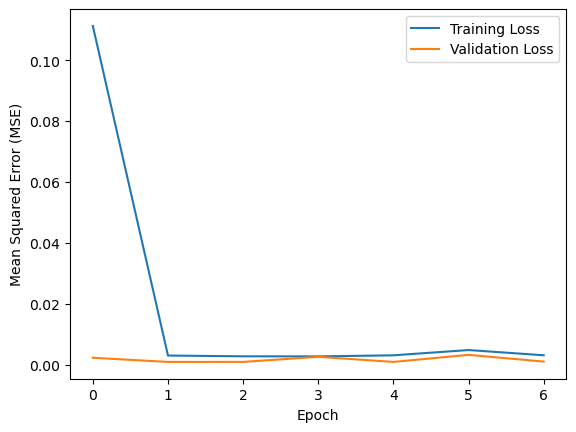

In [894]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()

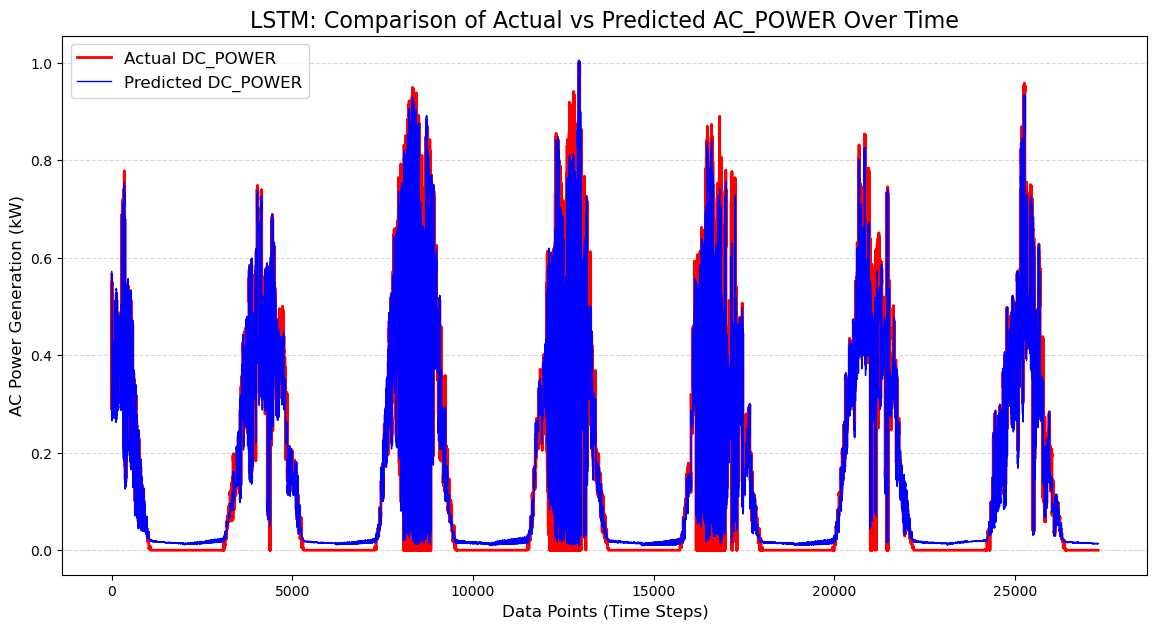

In [939]:
y_test_flat = y_test.flatten()
predictions_flat = predictions_best_model.flatten()

color_actual = 'red'
color_predicted = 'blue'
plt.figure(figsize=(14, 7))
# Plot the actual line in red
plt.plot(y_test_flat, color=color_actual, label='Actual DC_POWER', linewidth=2)


plt.plot(predictions_flat, color=color_predicted, label='Predicted DC_POWER', linewidth=1)

plt.title('LSTM: Comparison of Actual vs Predicted AC_POWER Over Time', fontsize=16)
plt.xlabel('Data Points (Time Steps)', fontsize=12)
plt.ylabel('AC Power Generation (kW)', fontsize=12)
plt.legend(fontsize=12, loc='upper left')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [941]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_flat, predictions_flat))
print(f"LSTM RMSE: {lstm_rmse}")

# Calculate MAE
lstm_mae = mean_absolute_error(y_test_flat, predictions_flat)
print(f"LSTM MAE: {lstm_mae}")

# Calculate R2 Score
lstm_r2 = r2_score(y_test_flat, predictions_flat)
print(f"LSTM R2 Score: {lstm_r2}")


LSTM RMSE: 0.030747177761774352
LSTM MAE: 0.022973057213569344
LSTM R2 Score: 0.9825680156191842


## 7. Model Comparisons

### **Model Performance Comparison**

### **Metrics Table**
| **Metric**        | **SARIMAX**   | **Prophet**   | **XGBoost**      | **LSTM**        |
|--------------------|---------------|---------------|------------------|-----------------|
| **R2 Score**       | 0.813709      | 0.879648      | -0.542846        | 0.982568        |
| **MAE**            | 2.255862      | 2.431660      | 0.004991         | 0.022973        |
| **RMSE**           | 4.022452      | 3.059362      | 0.009145         | 0.030747        |

---

### **Insights**

#### **R2 Score**
- **LSTM**: Achieves the highest R2 score (0.982568), indicating exceptional performance in explaining variance.
- **Prophet**: Outperforms SARIMAX with an R2 score of 0.879648, showcasing its strength in capturing trends and seasonality.
- **SARIMAX**: Reliable but falls behind Prophet and LSTM with a score of 0.813709.
- **XGBoost**: Negative R2 (-0.542846) suggests poor generalization, likely due to inadequate feature engineering or unsuitable hyperparameters.

#### **MAE (Mean Absolute Error)**
- **XGBoost**: Exhibits the lowest MAE (0.004991), making it highly effective at minimizing average prediction errors.
- **LSTM**: Has the second-lowest MAE (0.022973), demonstrating strong predictive performance.
- **SARIMAX**: Performs better than Prophet in MAE (2.255862 vs. 2.431660), making it useful in reducing absolute errors.

#### **RMSE (Root Mean Squared Error)**
- **XGBoost**: Minimizes RMSE (0.009145), highlighting its ability to reduce large deviations, closely followed by LSTM (0.030747).
- **Prophet**: Shows better RMSE performance than SARIMAX, demonstrating stronger capabilities at handling larger errors.
- **SARIMAX**: Has the highest RMSE among all models, indicating it struggles with larger prediction errors compared to other techniques.

---

### **Key Takeaways**
1. **Best Overall Model**:
   - **LSTM** stands out as the top-performing model, combining high accuracy (R2), low MAE, and RMSE. It is best suited for capturing nonlinear relationships and temporal dependencies.
   
2. **Secondary Choice**:
   - **Prophet** demonstrates robust performance in trend-heavy and seasonality-dependent datasets. It surpasses SARIMAX in both R2 and RMSE, making it a viable alternative.

3. **Utility of SARIMAX**:
   - While SARIMAX performs well in reducing average errors (MAE), it lags behind Prophet and LSTM in R2 and RMSE. It is best used for simpler time series forecasting tasks with less seasonality.

4. **XGBoost Performance**:
   - Despite its impressive MAE and RMSE metrics, the negative R2 score suggests room for improvement in feature engineering, model tuning, or inclusion of additional context variables. Potential overfitting concerns with lower observed metrics. 

5. **Recommendations for Future Work**:
   - Investigate ensemble methods combining SARIMAX and Prophet for improved trend and error reduction.
   - Fine-tune hyperparameters for XGBoost and consider adding additional weather metrics or other external regressors to enhance performance.
   - Expand LSTM exploration by incorporating additional data sources and increasing sequence lengths to capture long-term dependencies.

---


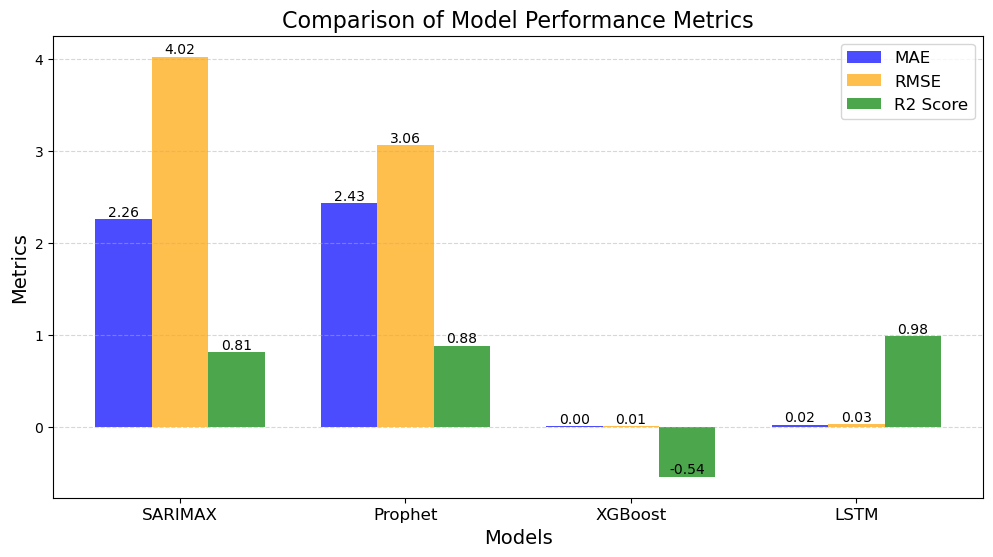

In [958]:
models = ['SARIMAX', 'Prophet', 'XGBoost', 'LSTM']
r2_scores = [0.813709, 0.879648, -0.542846, 0.982568]
mae_scores = [2.255862, 2.431660, 0.004991, 0.022973]
rmse_scores = [4.022452, 3.059362, 0.009145, 0.030747]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(12, 6))
bars_mae = plt.bar(x - width, mae_scores, width=width, label='MAE', color='blue', alpha=0.7)
bars_rmse = plt.bar(x, rmse_scores, width=width, label='RMSE', color='orange', alpha=0.7)
bars_r2 = plt.bar(x + width, r2_scores, width=width, label='R2 Score', color='green', alpha=0.7)

plt.xticks(x, models, fontsize=12)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.title('Comparison of Model Performance Metrics', fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate the bars with metric values
for bar in bars_mae:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=10)

for bar in bars_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=10)

for bar in bars_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=10)

plt.show()